In [1]:
from experiments.exp_3d.preprocessing import *
from losses.Metrics import metric_dice

from lib.visualize import display_instance
from experiments.exp_3d.inference import Pipeline

import matplotlib.pyplot as plt
import pandas as pd 

import pydicom
import pydicom_seg
import SimpleITK as sitk

In [2]:
target_size = (128, 128, 256)
target_spacing = (4.0, 4.0, 4.0)
target_direction = (1,0,0,0,1,0,0,0,1)
model_path = '/media/deeplearning/LACIE SHARE/RUDY_WEIGTH/training/20201125-17_00_45/trained_model_20201125-17_00_45.h5'
target_origin = None
from_pp = False

csv_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/inference.csv'


df = pd.read_csv(csv_path)
dataset = df[['study_id', 'ct_img', 'pet_img']].to_dict('records')
print(dataset)
print("")
pipeline = Pipeline(target_size, target_spacing, target_direction, model_path=model_path, target_origin=None, from_pp=False)
print("Pipeline object initialized")

[{'study_id': '1.2.250.1.59.453.859.92444169.1516.1370594209.2.1.1', 'ct_img': '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/1.2.250.1.59.453.859.92444169.1516.1370594209.2.1.1_nifti_CT.nii', 'pet_img': '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/1.2.250.1.59.453.859.92444169.1516.1370594209.2.1.1_nifti_PT.nii'}]

Pipeline object initialized


(263, 256, 256)
(263, 256, 256)


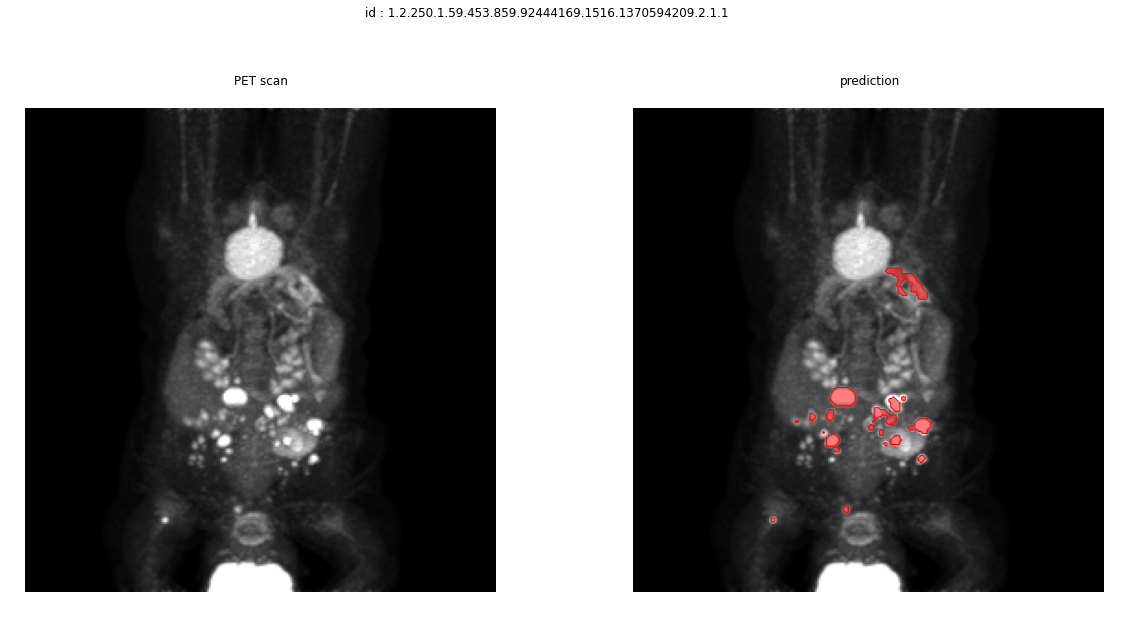

In [3]:
for count, img_path in enumerate(dataset) : 
    study_uid = img_path['study_id']
    pet_img = sitk.ReadImage(img_path['pet_img'], sitk.sitkFloat32)
    pet_spacing = pet_img.GetSpacing()
    pet_size = pet_img.GetSize()
    pet_origin = pet_img.GetOrigin()
    pet_direction = pet_img.GetDirection()
    #pet_array = np.rot90(sitk.GetArrayFromImage(pet_img),2)
    pet_array = sitk.GetArrayFromImage(pet_img)
    print(pet_array.shape)

    axis = 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle("id : {}".format(study_uid))
    display_instance(pet_array, mask_array=None, axis=axis, ax=ax1)
    ax1.set_title('PET scan')
    
    
    pred_nifti = pipeline(img_path)
    #print(str(type(pred_nifti)))
    #pred = np.rot90(sitk.GetArrayFromImage(pred_nifti),2)
    pred = sitk.GetArrayFromImage(pred_nifti)
    print(pred.shape)
    display_instance(pet_array, mask_array=pred, axis=axis, ax=ax2)
    ax2.set_title('prediction')

In [ ]:
#CHECK Nouvelle méthode pour contours 

In [ ]:
#SKIMAGE
import cv2
import skimage as sk 
print(pred_nifti.GetSize())
depth = pred_nifti.GetDepth()
print(depth)
contours = []
for i in range(depth):
    im = pred_nifti[:,:,i]
    array = sitk.GetArrayFromImage(im)
    #print(array.shape)
    contour = sk.measure.find_contours(array, level = 0.0)
    if contour != [] : 
        contours.append(contour)
    #print(contour)

In [27]:
pet_nifti = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/1.2.250.1.59.453.859.92444169.1516.1370594209.2.1.1_nifti_PT.nii'

img = sitk.ReadImage(pet_nifti)
spacing = img.GetSpacing()
direction = img.GetDirection()
origin = img.GetOrigin()



depth = pred_nifti.GetDepth()
contours = []

for i in range(depth):
    im = pred_nifti[:,:,i]
    contour = sitk.BinaryContour(im, fullyConnected=True )
    contours.append(contour)

vectorOfImages = sitk.VectorOfImage()
for contour in contours:
    vectorOfImages.push_back(contour)
img = sitk.JoinSeries(vectorOfImages)
img.SetDirection(direction)
img.SetSpacing(spacing)
img.SetOrigin(origin)

array = sitk.GetArrayFromImage(img)

In [36]:
#Image binaire + array binaire de CONTOURS 

z,x,y = np.where(array != 0)
print(x[0])
print(y[0])
print(z[0])
#new_contour = sitk.GetImageFromArray(array)
#new_contour.SetDirection(direction)
#new_contour.SetSpacing(spacing)
#new_contour.SetOrigin(origin)

img.TransformIndexToPhysicalPoint([135, 138, 87])

(2.734375, 2.734375, 3.2699999809265137)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(-348.6328125, -348.6328125, -759.989990234375)
135
138
87


(20.5078125, 28.7109375, -475.4999918937683)

In [ ]:
(2.734375, 2.734375, 3.2699999809265137)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(-348.6328125, -348.6328125, -759.989990234375)
135
138
87
(20.5078125, 28.7109375, -475.4999918937683)

### Generate DICOM-SEG

In [11]:
segmentation = pred_nifti
pet_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/1.2.250.1.59.453.859.92444169.1516.1370594209.2.2.8'
dicom_file = os.listdir(pet_path)

dicom_series_paths = [os.path.join(pet_path, x) for x in dicom_file]
source_images = [
    pydicom.dcmread(x, stop_before_pixels=True)
    for x in dicom_series_paths
]

json_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/Session1.json'
template = pydicom_seg.template.from_dcmqi_metainfo(json_path)

writer = pydicom_seg.MultiClassWriter(
    template=template,
    inplane_cropping=False,  # Crop image slices to the minimum bounding box on
                             # x and y axes. Maybe not supported by other frameworks.
    skip_empty_slices=True,  # Don't encode slices with only zeros
    skip_missing_segment=False,  # If a segment definition is missing in the
                                 # template, then raise an error instead of
                                 # skipping it.
)

dcm = writer.write(segmentation, source_images)
dcm.save_as(os.path.join('/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome','prediction_dicom_seg.dcm'))

### - Generate nifti 

In [4]:
#generate nifti 

#img = sitk.GetImageFromArray(np.transpose(pred, (1,2,0)))
print(pred.shape)
img = sitk.GetImageFromArray(np.flip(pred, axis = 0))
img.SetSpacing(pet_spacing)
img.SetOrigin(pet_origin)
img.SetDirection(pet_direction)

directory = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome'
filename = directory + '/'+ 'nifti_mask_prediction_v6.nii'
sitk.WriteImage(img, filename)

(263, 256, 256)


In [18]:
write_json_file('/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome', 'prediction_array', pred.tolist())

### - Generate RTStruct file 

In [14]:
from library_dicom.export_segmentation.ExportSegmentation_Writer import ExportSegmentation_Writer
from library_dicom.dicom_processor.tools.folders import *
from skimage.measure import label

#transformation to put mask on pet 
#transpose = np.flip(np.rot90(np.flip(np.transpose(pred, (1,2,0)), axis=2), k=2, axes=((0,1))), axis = 1)
#flip = np.flip(pred, axis = 0)
transpose = np.transpose(pred, axes=(1,2,0))

#generate rtstruct file 
pet_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/1.2.250.1.59.453.859.92444169.1516.1370594209.2.2.8'
ct_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome/'

transpose, number_features = label(transpose, connectivity=2, return_num = True)
print(transpose.shape)
print(np.max(transpose))
new_mask = np.zeros((transpose.shape))
x,y,z = np.where(transpose == 2)
new_mask[x,y,z] = 1 
x,y,z = np.where(transpose == 8) 
new_mask[x,y,z] = 2
print(np.max(new_mask))

mask_4D = np.expand_dims(new_mask, axis=-1)
#write_json_file('/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome', 'pet_array_multiple_roi', mask_4D.tolist())
mask_4D.shape

(256, 256, 263)
20
2.0


(256, 256, 263, 1)

In [16]:
#ExportSegmentation_Writer
writer = ExportSegmentation_Writer(mask_4D, pet_path, mode='rtstruct')

filename = 'rtss_prediction_mask_pet_ExpVR_2_ROI.dcm'
directory_path = '/media/deeplearning/LACIE SHARE/Olivier_Morel_sarcome'
writer.generate_dicom(filename, directory_path)